<a href="https://colab.research.google.com/github/BogdanT54/Serii-de-Timp/blob/Proiect/Analiza_META_(Proiect_Serii_Timp).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# Instalează pachetele necesare (rulat o singură dată)
!pip3 install yfinance statsmodels arch seaborn

In [14]:
# Importuri
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa.stattools as ts
from google.colab import files
from arch.unitroot import ADF, PhillipsPerron, KPSS
from statsmodels.stats.diagnostic import het_arch
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
warnings.filterwarnings('ignore')

In [16]:
#Descarc datele OHLC pentru ticker-ul META (Perioada similara cu cea a S&P500 din csv)
meta = yf.download('META', start='2015-11-23', end='2025-11-20', interval='1d')
meta.head()

[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['META']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,META,META,META,META,META,META
Date,,,,,,


In [17]:
#Prelucram randamentele logaritmice si curatam valorile lipsa
meta_log_returns = np.log(meta / meta.shift(1)).replace([np.inf, -np.inf], np.nan).dropna()
meta_log_returns.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,META,META,META,META,META,META
Date,,,,,,


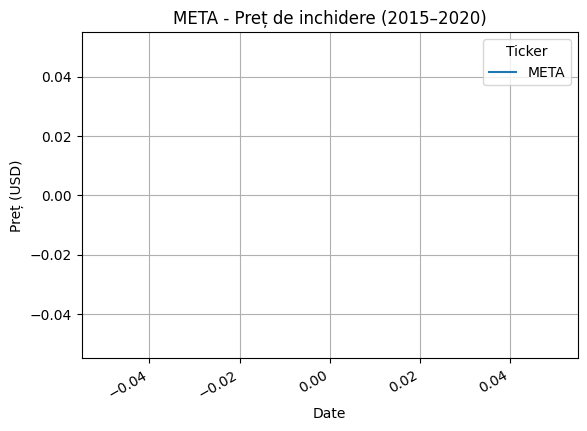

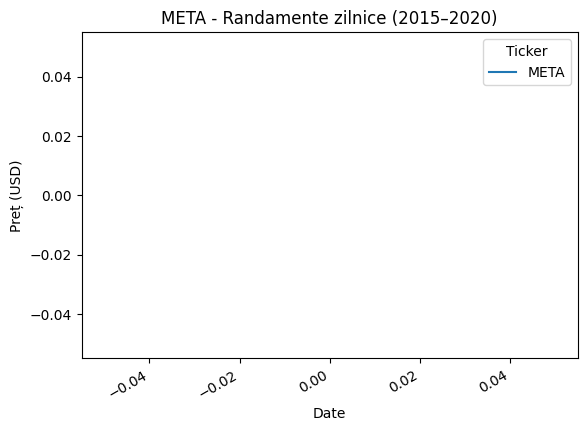

In [13]:
# Plot - Preț ajustat real
meta['Close'].plot(title='META - Preț de inchidere (2015–2020)')
plt.ylabel("Preț (USD)")
plt.grid(True)
plt.show()

#Plot pentru log randamente
meta_log_returns['Close'].plot(title='META - Randamente zilnice (2015–2020)')
plt.ylabel("Preț (USD)")
plt.show()

# **📈 Evoluția META (2015–2020)**

**🔹 Observații tehnice:**

Trend ascendent stabil până în 2021, urmat de volatilitate ridicată.

Corecție masivă în 2022, apoi revenire accelerată în 2023–2024.

Volatilitate extrem de mare la sfârșitul perioadei (2024–2025).

**🔹 Evenimente economice relevante:**

2021: Creștere datorată expansiunii platformelor Meta și optimismului tehnologic.

2022: Corecție severă cauzată de scăderea veniturilor, criza publicității online și incertitudini macroeconomice (războiul Rusia-Ucraina, inflație ridicată).

2023–2024: Revenire puternică pe fondul investițiilor în AI și eficientizării operaționale.

2025: Volatilitate crescută posibil asociată cu ajustări de piață și politici restrictive.

***⏩⏩⏩Deoarece trendul este stochastic (Seria urcă sau coboară la întâmplare, cu "salturi" de la o perioadă la alta) am aplicat diferentierea prin logaritmarea randametelor pentru a obtine un trend deterministic.***

# **📊 Randamente zilnice META**

**🔹 Observații tehnice:**

Randamente relativ stabile până în 2021.

Spike-uri majore în 2022 și 2023, indicând șocuri de piață.

Distribuție leptokurtică: valori extreme mai frecvente decât într-o distribuție normală.

**🔹 Interpretare:**

Randamentele zilnice sunt în general staționare, dar volatilitatea variază puternic în crize.

Modelarea volatilității este recomandată folosind modele ARCH/GARCH pentru a surprinde dinamica variației randamentelor.

In [ ]:
def analiza_trend(series, title=''):
    print(f'=== Analiza trend pentru {title} ===\n')

    # 2. Test ADF
    adf = ADF(series, trend='ct')
    print(adf.summary(),'\n')
    adf_stationary = adf.pvalue < 0.05

    # 3. Test KPSS
    kpss_test = KPSS(series, trend='ct')
    print(kpss_test.summary(),'\n')
    kpss_stationary = kpss_test.pvalue > 0.05

    # 4. Test Phillips-Perron
    pp = PhillipsPerron(series, trend='ct')
    print(pp.summary(),'\n')
    pp_stationary = pp.pvalue < 0.05

    # 5. Concluzie automată
    print('--- Concluzie ---')
    if adf_stationary and pp_stationary and kpss_stationary:
        print(f'Seria {title} are un trend determinist.')
    elif not adf_stationary and not pp_stationary and not kpss_stationary:
        print(f'Seria {title} are un trend stochastic.')
    else:
        print(f'Seria {title} necesită o analiză mai detaliată (rezultate mixte între teste).')
    print('=============================\n')

analiza_trend(meta['Close'], title='META - Close')
analiza_trend(meta_log_returns['Close'], title='META - Close')

In [ ]:
# ACF (pentru q – partea MA)
plt.figure(figsize=(10, 5))
plot_acf(meta_log_returns['Close'], lags=20, markersize=4)
plt.title('ACF - META Randamente')
plt.show()

# PACF (pentru p – partea AR)
plt.figure(figsize=(10, 5))
plot_pacf(meta_log_returns['Close'], lags=20, markersize=4)
plt.title('PACF - META Randamente')
plt.show()

In [ ]:
#Testare multiple modele ARIMA pentru META pentru a determina care este cel mai bun

#ARIMA (1,0,0)
model_meta_arima = ARIMA(meta_log_returns['Close'], order=( 1, 0, 0))
fitted = model_meta_arima.fit()
print(fitted.summary())

#ARIMA (0,0,1)
model_meta_arima = ARIMA(meta_log_returns['Close'], order=( 0, 0, 1))
fitted = model_meta_arima.fit()
print(fitted.summary())

#ARIMA (1,0,1)
model_meta_arima = ARIMA(meta_log_returns['Close'], order=( 1, 0, 1))
fitted = model_meta_arima.fit()
print(fitted.summary())

#ARIMA (2,0,1)
model_meta_arima = ARIMA(meta_log_returns['Close'], order=( 2, 0, 1))
fitted = model_meta_arima.fit()
print(fitted.summary())

#ARIMA (1,0,2)
model_meta_arima = ARIMA(meta_log_returns['Close'], order=( 1, 0, 2))
fitted = model_meta_arima.fit()
print(fitted.summary())

#ARIMA (2,0,2)
model_meta_arima = ARIMA(meta_log_returns['Close'], order=( 2, 0, 2))
fitted = model_meta_arima.fit()
print(fitted.summary())

#ARIMA (3,0,2)
model_meta_arima = ARIMA(meta_log_returns['Close'], order=( 3, 0, 2))
fitted = model_meta_arima.fit()
print(fitted.summary())

#ARIMA (2,0,3)
model_meta_arima = ARIMA(meta_log_returns['Close'], order=( 2, 0, 3))
fitted = model_meta_arima.fit()
print(fitted.summary())

| **Model**        | **AIC**          | **Coeficienți semnificativi?**                     | **Ljung-Box p-val** | **Observații**                                         |
| ---------------- | ---------------- | -------------------------------------------------- | ------------------- | ------------------------------------------------------ |
| **ARIMA(1,0,0)** | **🟩 -10828.57** | ✅ AR semnificativ (`p = 0.006`)                    | **0.98** (✔️✔️)     | 🏆 **Cel mai bun model – AIC minim, simplu, stabil**   |
| **ARIMA(0,0,1)** | -10828.47        | ✅ MA semnificativ (`p = 0.008`)                    | **0.99** (✔️✔️)     | Foarte apropiat de modelul anterior, dar ușor inferior |
| **ARIMA(1,0,1)** | -10827.36        | ❌ ambii coeficienți nesemnificativi (`p > 0.08`)   | **1.00** (✔️✔️)     | AIC competitiv, dar coeficienți instabili              |
| **ARIMA(2,0,1)** | -10824.88        | ❌ toți coeficienții nesemnificativi (`p > 0.85`)   | **1.00** (✔️✔️)     | Overfitting fără valoare adăugată                      |
| **ARIMA(1,0,2)** | -10824.54        | ❌ toți coeficienții nesemnificativi (`p > 0.78`)   | **0.99** (✔️✔️)     | Suprapotrivire, instabilitate în estimări              |
| **ARIMA(2,0,2)** | -10822.85        | ❌ coeficienți complet nesemnificativi (`p > 0.99`) | **1.00** (✔️✔️)     | Parametri inutili, complexitate inutilă                |
| **ARIMA(3,0,2)** | -10822.87        | ❌ coeficienți nesemnificativi (`p > 0.96`)         | **0.99** (✔️✔️)     | Niciun câștig real față de modele mai simple           |
| **ARIMA(2,0,3)** | -10823.09        | ❌ aproape toți coeficienții nesemnificativi        | **0.97** (✔️✔️)     | Overfitting ușor, instabilitate clară                  |


# **✅ După criteriile Box-Jenkins:**

ARIMA(1,0,0) este cel mai bun model global:

AIC minim absolut

Coeficientul AR semnificativ (p = 0.006)

Reziduuri neautocorelate (Ljung-Box p ≈ 0.98)

# **❌ Însă și în acest caz, ipotezele econometrice fundamentale sunt încălcate:**

**Reziduuri nenormale:**

Toate modelele au testul Jarque-Bera extrem de semnificativ (p = 0.00)

Skew negativ puternic (~ -1.18), kurtosis foarte mare (~29)

➤ Cozi groase (heavy tails), abateri de la normalitate — tipic pentru randamente financiare

**Heteroscedasticitate (varianță inconstantă):**

H ≈ 2.50, cu p < 0.01 în toate modelele → indică volatilitate condițională

➤ Ipoteza de varianță constantă este încălcată

Coeficienți instabili în modelele mai complexe:

Modele precum ARIMA(2,0,1), ARIMA(1,0,2), ARIMA(2,0,3) au coeficienți cu erori standard foarte mari → instabilitate numerică → overfitting

# **⚠️ Concluzie riguroasă**

Deși modelul ARIMA(1,0,0) este cel mai potrivit din perspectiva criteriilor clasice (AIC, semnificație, reziduuri), acesta nu respectă ipotezele econometrice fundamentale, esențiale pentru validitatea inferenței: